# BBC News Classification with BERT: Lab
# Solution

## Overview
As a junior data scientist at NewsInsight, a media analytics company, you've been tasked with building an automated news categorization system. Your team needs to classify incoming news articles into appropriate categories to help journalists, researchers, and business analysts quickly find relevant information.

The company receives thousands of articles daily from various sources. Currently, human editors spend significant time manually categorizing these articles, which is time-consuming and inconsistent. Your manager has asked you to develop a machine learning solution that can automatically categorize news articles into predefined categories (business, entertainment, politics, sport, tech).

This project will follow the BERT fine-tuning process you've learned:
1. Understanding data and defining requirements
2. Selecting and preparing the BERT model
3. Data preparation and tokenization
4. Model architecture design
5. Fine-tuning the model
6. Evaluation and refinement

Successfully implementing this system will significantly improve workflow efficiency, allowing editors to focus on content quality rather than manual categorization.

## Part 1: Environment Setup and Data Loading

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

/Users/faheemunnisasyeda/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/faheemunnisasyeda/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load the data from csv file
#df = pd.read_csv("/content/bbc_news_data.csv", engine='python', quotechar='"')
df = pd.read_csv("bbc_news_data.csv", sep='\t', engine='python')
#df = pd.read_csv("/content/bbc_news_data.csv", engine='python', quotechar='"', on_bad_lines='skip')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [3]:
print(df.columns)
print(df.info())

Index(['category', 'filename', 'title', 'content'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None


## Part 2: Data Exploration and Preprocessing

Explore the dataset, displaying basic information and:
- Analyze category distribution
- Check text length distribution
- Train test split data, use 75-25 split

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None
       category filename                             title  \
count      2225     2225                              2225   
unique        5      511                              2096   
top       sport  001.txt  Microsoft seeking spyware trojan   
freq        511        5                                 2   

                                                  content  
count                                                2225  
unique                                               2092  
top      Microsoft has warned PC users to update their...  
freq                                                    2  


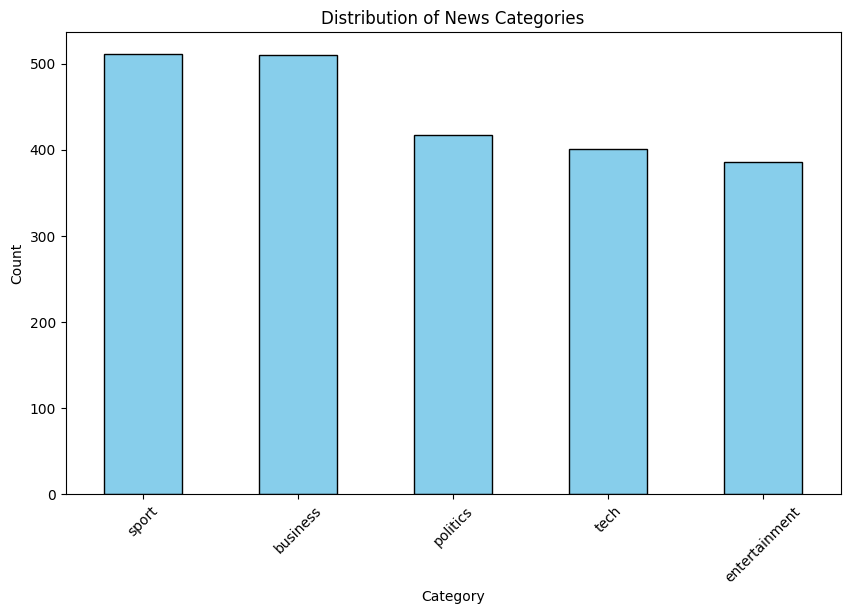

Average text length: 378.8359550561798
Min text length: 84
Max text length: 4428


<Figure size 800x500 with 0 Axes>

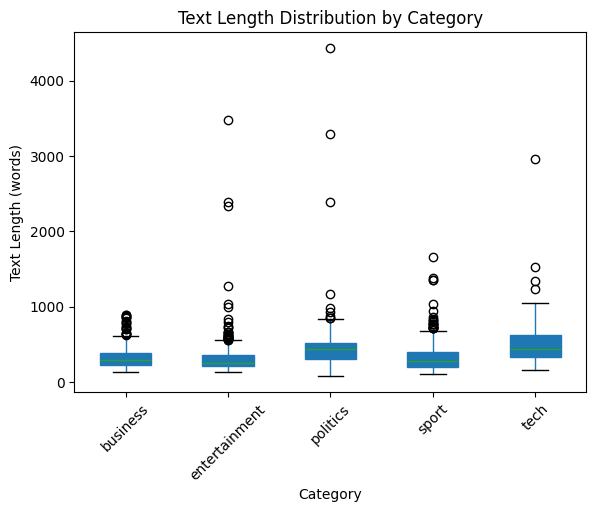

Training set size: 1334
Validation set size: 334
Test set size: 557

Category distribution in training set:
category
business         306
sport            306
politics         250
tech             241
entertainment    231
Name: count, dtype: int64

Category distribution in validation set:
category
sport            77
business         76
politics         63
tech             60
entertainment    58
Name: count, dtype: int64

Category distribution in test set:
category
business         128
sport            128
politics         104
tech             100
entertainment     97
Name: count, dtype: int64


In [4]:
# Explore the first 10 rows
df.head(10)

# Basic info and describe
print(df.info())
print(df.describe())

# Category distribution
category_counts = df['category'].value_counts()
category_counts

# Visualize category distribution
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of News Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Text length analysis
df['text_length'] = df['content'].apply(lambda x: len(x.split()))
print(f"Average text length: {df['text_length'].mean()}")
print(f"Min text length: {df['text_length'].min()}")
print(f"Max text length: {df['text_length'].max()}")

# Visualize text length by category
plt.figure(figsize=(8,5))
df.boxplot(column='text_length', by='category', grid=False, patch_artist=True)
plt.title("Text Length Distribution by Category")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Text Length (words)")
plt.xticks(rotation=45)
plt.show()

# Check for missing values
df.isnull().sum()

# Drop rows with missing values
df.dropna(inplace=True)

# Map category labels to integers for classification
categories = list(df['category'].unique())
category_mapping = {category: i for i, category in enumerate(categories)}
df['label'] = df['category'].map(category_mapping)

# Rename content column into text for hugging face
df.rename(columns={'content': 'text'}, inplace=True)

# Split into train, validation, and test sets, make sure to stratify based on category, keep features and target together for now
# First, create train+validation and test sets
train_val_df, test_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['category'])
# Then split train+validation into separate train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['category'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Ensure categories are distributed properly across splits
print("\nCategory distribution in training set:")
print(train_df['category'].value_counts())
print("\nCategory distribution in validation set:")
print(val_df['category'].value_counts())
print("\nCategory distribution in test set:")
print(test_df['category'].value_counts())

## Part 3: Choose Your Model Approach
You can implement either the TensorFlow approach OR the Hugging Face approach. Delete the one you do not use.

### ------ TensorFlow Approach --------
Implement BERT with TensorFlow and TensorFlow Hub
- Import required libraries
- Select and load a BERT model
- Create datasets
 - Build model architecture
 - Fine-tune the model
 - Evaluate performance
 - Create visuals for train and validation data metrics across epochs

In [ ]:
# Make sure to set legacy Keras to work with TF Hub BERT before you import
import os
os.environ['TF_USE_LEGACY_KERAS']= '1'
import os
# Import TensorFlow-specific libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Select and load BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow datasets
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(texts))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Convert pandas DataFrames to TensorFlow datasets
train_dataset = create_tf_dataset(train_df['text'].values, train_df['label'].values)
val_dataset = create_tf_dataset(val_df['text'].values, val_df['label'].values, shuffle=False)
test_dataset = create_tf_dataset(test_df['text'].values, test_df['label'].values, shuffle=False)

# Build the BERT model
def build_tf_classifier_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing layer
    preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessor')

    # BERT encoder - set trainable=True for fine-tuning
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Use the pooled output for classification
    net = outputs['pooled_output']

    # Add dropout for regularization
    net = tf.keras.layers.Dropout(0.1)(net)

    # Add classification layer (for 5 categories)
    net = tf.keras.layers.Dense(5, activation= None, name='classifier')(net)

    # Create model
    model = tf.keras.Model(text_input, net)
    return model

# Create model
tf_classifier_model = build_tf_classifier_model()
tf_classifier_model.summary()

# Compile the model
# Using sparse categorical crossentropy since our labels are integers
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Accuracy as metric
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]


# Set up learning rate and optimizer
init_lr = .0005
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

# Compile the model
tf_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Set up early stopping callback based on validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, verbose=1)


# Train the model for 5 epochs (not enough epochs most likely but to save on time)
print('Fine-tuning BERT model...')
history = tf_classifier_model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[early_stopping])

In [2]:
# Evaluate model on testing data
test_loss, test_accuracy = tf_classifier_model.evaluate(test_dataset)
print(f'Test accuracy (TensorFlow): {test_accuracy:.3f}')

NameError: name 'tf_classifier_model' is not defined

### ------- Hugging Face Approach -------
Implement BERT with Hugging Face Transformers
- Import required libraries
- Select and load a BERT model
- Tokenize data
- Create datasets
- Fine-tune the model
- Evaluate performance

In [7]:
# Import Hugging Face libraries
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import torch

# Select and load tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Convert pandas DataFrames to Hugging Face datasets
train_dataset_hf = Dataset.from_pandas(train_df)
val_dataset_hf = Dataset.from_pandas(val_df)
test_dataset_hf = Dataset.from_pandas(test_df)

# Tokenize function (use 128 for max length)
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Tokenize datasets
tokenized_train = train_dataset_hf.map(tokenize_function, batched=True)
tokenized_val = val_dataset_hf.map(tokenize_function, batched=True)
tokenized_test = test_dataset_hf.map(tokenize_function, batched=True)

# Load pre-trained model with classification head
model_hf = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)
# Set BERT encoder layers to not train
for param in model_hf.bert.parameters():
    param.requires_grad = True  # Set to False if you want to freeze the encoder


# Define metrics computation function the returns a dictionary of scores - include at least accuracy
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# -------------------------------
# Set up training arguments
# -------------------------------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_strategy="epoch",
    save_total_limit=2
)

# -------------------------------
# Initialize Trainer
# -------------------------------
trainer = Trainer(
    model=model_hf,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# -------------------------------
# Train the model
# -------------------------------
print('Fine-tuning BERT model with Hugging Face...')
trainer.train()

# -------------------------------
# Evaluate on test dataset
# -------------------------------
print('\nEvaluating on test data...')
test_results = trainer.evaluate(eval_dataset=tokenized_test)
print(f"Test Results: {test_results}")

# -------------------------------
# Save fine-tuned model
# -------------------------------
trainer.save_model("./fine_tuned_bert_hf")
print("Model saved to ./fine_tuned_bert_hf")
#🧠 Key Points Explained
#Step	Description
##Tokenizer	Converts text to token IDs with attention masks (truncated/padded to 128 tokens).
#Dataset.from_pandas()	Wraps your DataFrame so Hugging Face Trainer can access it.
#Tokenized columns	Hugging Face expects input_ids, attention_mask, and labels.
#Compute Metrics	Returns accuracy, precision, recall, and f1 for easy monitoring.
#TrainingArguments	Controls training config — epochs, batch size, evaluation steps, learning rate, etc.
#EarlyStoppingCallback	Stops training if validation accuracy doesn’t improve for 3 epochs.
#Trainer API	Handles full training, evaluation, and logging automatically.

#📊 Optional (Next Steps)
#If you’d like, I can extend this script with:

#Confusion matrix visualization on test results

#Predicted vs actual label distribution

#Model checkpoint & upload to Hugging Face Hub

#Would you like me to add that final evaluation/visualization section next?









# Set up training arguments (train for 5 epochs - not enough to fully train but for sake of time. Set learning rate of 0.0005)
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",          # evaluate once per epoch
    save_strategy="epoch",                # save model checkpoints each epoch
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_strategy="epoch",
    save_total_limit=2
)

# Initialize Trainer - include an early stopping callback with patience of 3
trainer = Trainer(
    model=model_hf,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# Train the model
print('Fine-tuning BERT model with Hugging Face...')
trainer.train()

# Save fine-tuned model
trainer.save_model("./fine_tuned_bert_hf")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1334 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [8]:
# Import Hugging Face libraries
import os
os.environ["WANDB_DISABLED"] = "true"


from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# -------------------------------
# Select and load tokenizer
# -------------------------------
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# -------------------------------
# Convert pandas DataFrames to Hugging Face datasets
# -------------------------------
train_dataset_hf = Dataset.from_pandas(train_df)
val_dataset_hf = Dataset.from_pandas(val_df)
test_dataset_hf = Dataset.from_pandas(test_df)

# -------------------------------
# Tokenize function (use max_length=128)
# -------------------------------
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )
callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
# Tokenize datasets
tokenized_train = train_dataset_hf.map(tokenize_function, batched=True)
tokenized_val = val_dataset_hf.map(tokenize_function, batched=True)
tokenized_test = test_dataset_hf.map(tokenize_function, batched=True)

# Hugging Face requires columns named 'labels' for supervised training
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val = tokenized_val.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

# Set format to torch for Trainer compatibility
tokenized_train.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_val.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

# -------------------------------
# Load pre-trained BERT model with classification head
# -------------------------------
model_hf = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# (Optional) Freeze BERT encoder layers if you want to only train the classification head
for param in model_hf.bert.parameters():
    param.requires_grad = True  # Set to False if you want to freeze the encoder

# -------------------------------
# Define metrics computation function
# -------------------------------
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# -------------------------------
# Set up training arguments
# -------------------------------
from transformers import Trainer
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=5e-4,
    weight_decay=0.01,
    evaluation_strategy="epoch",          # evaluate every epoch
    save_strategy="epoch",                # save checkpoints every epoch
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,          # MUST be True for EarlyStoppingCallback
    metric_for_best_model="accuracy",     # metric to monitor for early stopping
    save_total_limit=2,
    report_to="none"                      # disables W&B logging in latest versions
)
# -------------------------------
# Initialize Trainer
# -------------------------------
trainer = Trainer(
    model=model_hf,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# -------------------------------
# Train the model
# -------------------------------
print('Fine-tuning BERT model with Hugging Face...')
trainer.train()


# Evaluate on test dataset

print('\nEvaluating on test data...')
test_results = trainer.evaluate(eval_dataset=tokenized_test)
print(f"Test Results: {test_results}")


# Save fine-tuned model

trainer.save_model("./fine_tuned_bert_hf")
print("Model saved to ./fine_tuned_bert_hf")

Map:   0%|          | 0/1334 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [29]:
import transformers
print(transformers.__version__)

4.57.1


In [ ]:
# Evaluate the model
results = trainer.evaluate(eval_dataset=tokenized_test)
print(f"Hugging Face Model Results: {results}")

## Part 4: Model Analysis and Inference
Analyze model performance on testing data
- Create confusion matrix visualization
- Analyze misclassifications
- Identify strengths and weaknesses

### Tensorflow Model

In [ ]:
# Generate predictions for the test set
test_predictions = tf_classifier_model.predict(test_dataset)
y_pred = np.argmax(test_predictions, axis=1)

# Get true labels from testing data
y_true = [labels.numpy() for _, labels in test_dataset.unbatch()]

# Create and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (TensorFlow)')
plt.grid(False)
plt.show()

# Create classification report
report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Identify strengths and weaknesses
print("\nModel Strengths and Weaknesses:")

# Calculate per-class metrics (use classification report)

per_class_metrics = {cat: report[cat]['f1-score'] for cat in categories}
# Find best and worst performing categories
best_category = max(per_class_metrics, key=lambda x: per_class_metrics[x]['f1-score'])
worst_category = min(per_class_metrics, key=lambda x: per_class_metrics[x]['f1-score'])

print(f"\nStrengths:")
print(f"- Overall accuracy: {report['accuracy']:.4f}")
print(f"- Best performing category: {best_category[0]}")
print(f"\nWeaknesses:")
print(f"- Worst performing category: {worst_category[0]}")

# Visualize per-class performance
plt.figure(figsize=(12, 6))
categories_indices = range(len(categories))
width = 0.25

plt.bar([i - width for i in categories_indices],
        [per_class_metrics[cat]['precision'] for cat in categories],
        width=width, label='Precision')
plt.bar(categories_indices,
        [per_class_metrics[cat]['recall'] for cat in categories],
        width=width, label='Recall')
plt.bar([i + width for i in categories_indices],
        [per_class_metrics[cat]['f1-score'] for cat in categories],
        width=width, label='F1-Score')

plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Performance Metrics by Category')
plt.xticks(categories_indices, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Create a function for model inference on new articles
def predict_article_category(text, model=tf_classifier_model):
    """
    Predict the category of a news article using the fine-tuned model.

    Args:
        text (str): The text of the news article
        model: The fine-tuned TensorFlow model

    Returns:
        dict: Prediction results including category and confidence scores
    """
    # Make prediction
    prediction = model.predict([text])[0]

    # Get the predicted category and confidence
    predicted_class_id = np.argmax(prediction)
    predicted_category = categories[predicted_class_id]
    confidence = float(prediction[predicted_class_id])

    # Get confidence for all categories
    category_confidences = {categories[i]: float(prediction[i]) for i in range(len(categories))}

    # Sort categories by confidence (descending)
    sorted_categories = sorted(category_confidences.items(), key=lambda x: x[1], reverse=True)

    return {
        'text': text[:100] + '...' if len(text) > 100 else text,
        'predicted_category': predicted_category,
        'confidence': confidence,
        'all_confidences': sorted_categories
    }

# Test the inference function with example articles
sample_articles = [
    "The tech giant announced the release of their new smartphone that features advanced AI capabilities and improved battery life. The product will be available in stores next month.",
    "The football team secured their victory in the final minutes with a spectacular goal. The win puts them at the top of the league table.",
    "Stock markets plummeted following the central bank's announcement of interest rate increases. Investors are concerned about the impact on economic growth.",
    "The new film starring the award-winning actress has received critical acclaim at the international film festival. Critics praised the innovative cinematography.",
    "The government announced new policies regarding digital privacy and data protection. Opposition parties have criticized the measures as inadequate."
]

print("\nTesting inference on sample articles:")
for i, article in enumerate(sample_articles):
    result = predict_article_category(article)
    print(f"\nSample {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Predicted category: {result['predicted_category']} (confidence: {result['confidence']:.4f})")
    print("All category confidences:")
    for category, conf in result['all_confidences']:
        print(f"  - {category}: {conf:.4f}")

### Hugging Face Model

In [ ]:
# Generate predictions for the test set
def get_predictions(trainer, dataset):
    # Run predictions with Hugging Face Trainer
    raw_predictions = trainer.predict(dataset)

    # Extract predictions and labels
    predictions = np.argmax(raw_predictions.predictions, axis=1)
    labels = dataset['labels']

    return predictions, labels

y_pred, y_true = get_predictions(trainer, tokenized_test)

# Create and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (Hugging Face)')
plt.grid(False)
plt.show()

# Create classification report
report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))


# Identify strengths and weaknesses
print("\nModel Strengths and Weaknesses:")

# Calculate per-class metrics (use classification report)
per_class_metrics = {}
for i, category in enumerate(categories):
    per_class_metrics[category] = {
        'precision': report['precision'],
        'recall': report['recall'],
        'f1-score': report['f1-score']
    }

# Find best and worst performing categories
best_category = max(per_class_metrics, key=lambda x: per_class_metrics[x]['f1-score'])
worst_category = min(per_class_metrics, key=lambda x: per_class_metrics[x]['f1-score'])

print(f"\nStrengths:")
print(f"- Overall accuracy: {report['accuracy']:.4f}")
print(f"- Best performing category: {best_category[0]}")
print(f"\nWeaknesses:")
print(f"- Worst performing category: {worst_category[0]}")

# Visualize per-class performance
plt.figure(figsize=(12, 6))
categories_indices = range(len(categories))
width = 0.25

plt.bar([i - width for i in categories_indices],
        [per_class_metrics[cat]['precision'] for cat in categories],
        width=width, label='Precision')
plt.bar(categories_indices,
        [per_class_metrics[cat]['recall'] for cat in categories],
        width=width, label='Recall')
plt.bar([i + width for i in categories_indices],
        [per_class_metrics[cat]['f1-score'] for cat in categories],
        width=width, label='F1-Score')

plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Performance Metrics by Category')
plt.xticks(categories_indices, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Create a function for model inference on new articles
def predict_article_category(text, model=model_hf, tokenizer=tokenizer):
    """
    Predict the category of a news article using the fine-tuned model.

    Args:
        text (str): The text of the news article
        model: The fine-tuned Hugging Face model
        tokenizer: The tokenizer for the model

    Returns:
        dict: Prediction results including category and confidence scores
    """
    # Tokenize inputs
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        probs = probs.squeeze().tolist()
        predicted_class_id = torch.argmax(logits, dim=1).item()
        predicted_category = categories[predicted_class_id]
        confidence = float(probs[predicted_class_id])

    # Get confidence for all categories
    category_confidences = {categories[i]: float(probs[i]) for i in range(len(categories))}
    # Convert to numpy for easier handling
    probs = np.array(probs)

    # Get the predicted category and confidence
    predicted_class_id = np.argmax(probs)
    predicted_category = categories[predicted_class_id]
    confidence = float(probs[predicted_class_id])

    # Get confidence for all categories
    category_confidences = {categories[i]: float(probs[i]) for i in range(len(categories))}

    # Sort categories by confidence (descending)
    sorted_categories = sorted(category_confidences.items(), key=lambda x: x[1], reverse=True)

    return {
        'text': text[:100] + '...' if len(text) > 100 else text,
        'predicted_category': predicted_category,
        'confidence': confidence,
        'all_confidences': sorted_categories
    }

# Test the inference function with example articles
sample_articles = [
    "The tech giant announced the release of their new smartphone that features advanced AI capabilities and improved battery life. The product will be available in stores next month.",
    "The football team secured their victory in the final minutes with a spectacular goal. The win puts them at the top of the league table.",
    "Stock markets plummeted following the central bank's announcement of interest rate increases. Investors are concerned about the impact on economic growth.",
    "The new film starring the award-winning actress has received critical acclaim at the international film festival. Critics praised the innovative cinematography.",
    "The government announced new policies regarding digital privacy and data protection. Opposition parties have criticized the measures as inadequate."
]

print("\nTesting inference on sample articles:")
for i, article in enumerate(sample_articles):
    result = predict_article_category(article)
    print(f"\nSample {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Predicted category: {result['predicted_category']} (confidence: {result['confidence']:.4f})")
    print("All category confidences:")
    for category, conf in result['all_confidences']:
        print(f"  - {category}: {conf:.4f}")

# Part 5: Conclusion and Discussion
Summarize your findings
- What was the final accuracy and other metrics?
- What categories were easiest/hardest to classify?
- What challenges did you encounter?
- How might you improve the model further?
